## Space Technology - For use of travel or activities beyond earth's atmosphere, for purposes such as spaceflight or space exploration.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import joblib

In [2]:
data = pd.read_csv('space_decay.csv')

In [3]:
print(data.head())

   CCSDS_OMM_VERS                            COMMENT        CREATION_DATE  \
0               2  GENERATED VIA SPACE-TRACK.ORG API  2021-11-01T06:46:11   
1               2  GENERATED VIA SPACE-TRACK.ORG API  2021-11-01T04:58:37   
2               2  GENERATED VIA SPACE-TRACK.ORG API  2021-11-01T06:26:11   
3               2  GENERATED VIA SPACE-TRACK.ORG API  2021-10-31T18:07:15   
4               2  GENERATED VIA SPACE-TRACK.ORG API  2021-11-01T04:58:37   

  ORIGINATOR      OBJECT_NAME   OBJECT_ID CENTER_NAME REF_FRAME TIME_SYSTEM  \
0    18 SPCS  ARIANE 42P+ DEB   1992-072J       EARTH      TEME         UTC   
1    18 SPCS         SL-8 DEB   1979-028C       EARTH      TEME         UTC   
2    18 SPCS           GSAT 1   2001-015A       EARTH      TEME         UTC   
3    18 SPCS         CZ-4 DEB  1999-057MB       EARTH      TEME         UTC   
4    18 SPCS         CZ-4 DEB  1999-057MC       EARTH      TEME         UTC   

  MEAN_ELEMENT_THEORY  ... RCS_SIZE  COUNTRY_CODE  LAUNCH_DATE

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CCSDS_OMM_VERS       14372 non-null  int64  
 1   COMMENT              14372 non-null  object 
 2   CREATION_DATE        14372 non-null  object 
 3   ORIGINATOR           14372 non-null  object 
 4   OBJECT_NAME          14372 non-null  object 
 5   OBJECT_ID            14333 non-null  object 
 6   CENTER_NAME          14372 non-null  object 
 7   REF_FRAME            14372 non-null  object 
 8   TIME_SYSTEM          14372 non-null  object 
 9   MEAN_ELEMENT_THEORY  14372 non-null  object 
 10  EPOCH                14372 non-null  object 
 11  MEAN_MOTION          14372 non-null  float64
 12  ECCENTRICITY         14372 non-null  float64
 13  INCLINATION          14372 non-null  float64
 14  RA_OF_ASC_NODE       14372 non-null  float64
 15  ARG_OF_PERICENTER    14372 non-null 

In [5]:
print(data.describe())

       CCSDS_OMM_VERS   MEAN_MOTION  ECCENTRICITY   INCLINATION  \
count         14372.0  14372.000000  14372.000000  14372.000000   
mean              2.0     12.463847      0.067168     74.354208   
std               0.0      4.509305      0.181547     29.626780   
min               2.0      0.051783      0.000005      0.001400   
25%               2.0     13.452144      0.000725     53.055300   
50%               2.0     14.277052      0.003416     86.369200   
75%               2.0     14.963745      0.013505     98.565125   
max               2.0     16.404097      0.897218    144.586200   

       RA_OF_ASC_NODE  ARG_OF_PERICENTER  MEAN_ANOMALY  EPHEMERIS_TYPE  \
count    14372.000000       14372.000000  14372.000000         14372.0   
mean       182.353111         165.977199    191.015595             0.0   
std        116.717713         104.461866    109.873807             0.0   
min          0.020000           0.008200      0.004800             0.0   
25%         71.987350     

In [6]:
# Step 3: Handle Missing Values
# Replace missing values for categorical columns with the mode
data['OBJECT_ID'].fillna(data['OBJECT_ID'].mode()[0], inplace=True)
data['COUNTRY_CODE'].fillna(data['COUNTRY_CODE'].mode()[0], inplace=True)
data['RCS_SIZE'].fillna('UNKNOWN', inplace=True)

C:\Users\jaya sai srikar\AppData\Local\Temp\ipykernel_15156\132467298.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['OBJECT_ID'].fillna(data['OBJECT_ID'].mode()[0], inplace=True)
C:\Users\jaya sai srikar\AppData\Local\Temp\ipykernel_15156\132467298.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [7]:
data.drop(columns=['COMMENT', 'DECAY_DATE'], inplace=True)

In [8]:
# Step 4: Convert Categorical Variables to Numerical Format
categorical_features = ['OBJECT_TYPE', 'CLASSIFICATION_TYPE', 'COUNTRY_CODE', 'RCS_SIZE']
for col in categorical_features:
    data[col] = LabelEncoder().fit_transform(data[col])

In [9]:
data['CREATION_DATE'] = pd.to_datetime(data['CREATION_DATE'])
data['LAUNCH_DATE'] = pd.to_datetime(data['LAUNCH_DATE'], errors='coerce')

In [10]:
# Drop unused or non-numeric columns
unused_columns = ['OBJECT_NAME', 'ORIGINATOR', 'CENTER_NAME', 'REF_FRAME', 'TIME_SYSTEM', 'MEAN_ELEMENT_THEORY', 'EPOCH', 'SITE', 'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2']
data.drop(columns=unused_columns, inplace=True)

In [11]:
# Ensure all remaining columns are numeric
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
X = data[numeric_columns].drop('OBJECT_TYPE', axis=1)  # Features only
y = data['OBJECT_TYPE']  # Target is OBJECT_TYPE

In [12]:
# Normalize/Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [14]:
##models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [15]:
results = {}

In [16]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[model_name] = report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1701
           1       0.84      0.90      0.87       954
           2       0.74      0.44      0.55       172
           3       1.00      0.08      0.15        48

    accuracy                           0.90      2875
   macro avg       0.88      0.60      0.63      2875
weighted avg       0.90      0.90      0.89      2875

[[1643   41   17    0]
 [  83  862    9    0]
 [  17   80   75    0]
 [   6   38    0    4]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1701
           1       0.94      0.98      0.96       954
           2       0.95      0.73      0.83       172
           3       0.93      0.81      0.87        48

    accuracy                           0.96      2875
   macro avg       0.95      0.88      0.91      2875
weighted a

In [17]:
param_grid = {
    'n_estimators':[50,100,200],'max_depth':[None,10,20,30],'min_samples_split':[2,5,10]
}

In [18]:
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [19]:
print("\nBest Hyperparameters for Random Forest:")
print(grid_search.best_params_)


Best Hyperparameters for Random Forest:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


In [20]:
# Retrain the best model with optimal hyperparameters
best_rf_model=grid_search.best_estimator_
best_rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [21]:
# Final Model Evaluation
y_pred_final=best_rf_model.predict(X_test)
print("\nFinal Model Evaluation - Random Forest:")
print(classification_report(y_test,y_pred_final))
print(confusion_matrix(y_test,y_pred_final))


Final Model Evaluation - Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1701
           1       0.93      0.97      0.95       954
           2       0.92      0.77      0.84       172
           3       0.91      0.67      0.77        48

    accuracy                           0.96      2875
   macro avg       0.94      0.85      0.89      2875
weighted avg       0.96      0.96      0.96      2875

[[1674   23    4    0]
 [  15  929    7    3]
 [  10   30  132    0]
 [   2   14    0   32]]


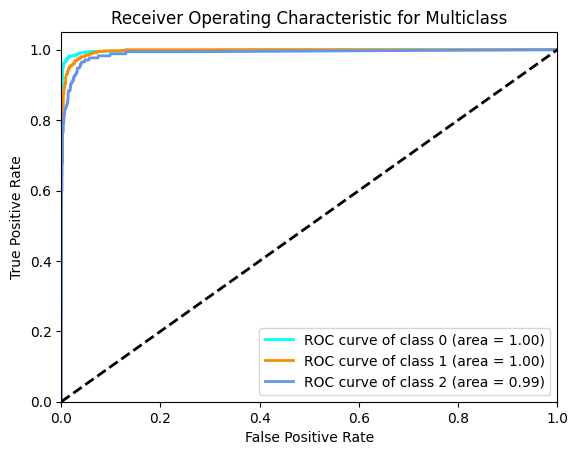

In [22]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Binarize the output for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Replace with actual class labels if needed
n_classes = y_test_bin.shape[1]

# Train the model using OneVsRest strategy
ovr_rf_model = OneVsRestClassifier(RandomForestClassifier(random_state=42))
ovr_rf_model.fit(X_train, y_train)

# Get predicted probabilities
y_pred_prob = ovr_rf_model.predict_proba(X_test)

# Plotting ROC curves for each class
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(n_classes):
    fpr[i],tpr[i],_=roc_curve(y_test_bin[:,i],y_pred_prob[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
plt.figure()
colors=['aqua','darkorange','cornflowerblue']
for i, color in zip(range(n_classes),colors):
    plt.plot(fpr[i],tpr[i],color=color,lw=2,
             label='ROC curve of class{0}(area={1:0.2f})'
             ''.format(i,roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc="lower right")
plt.show()

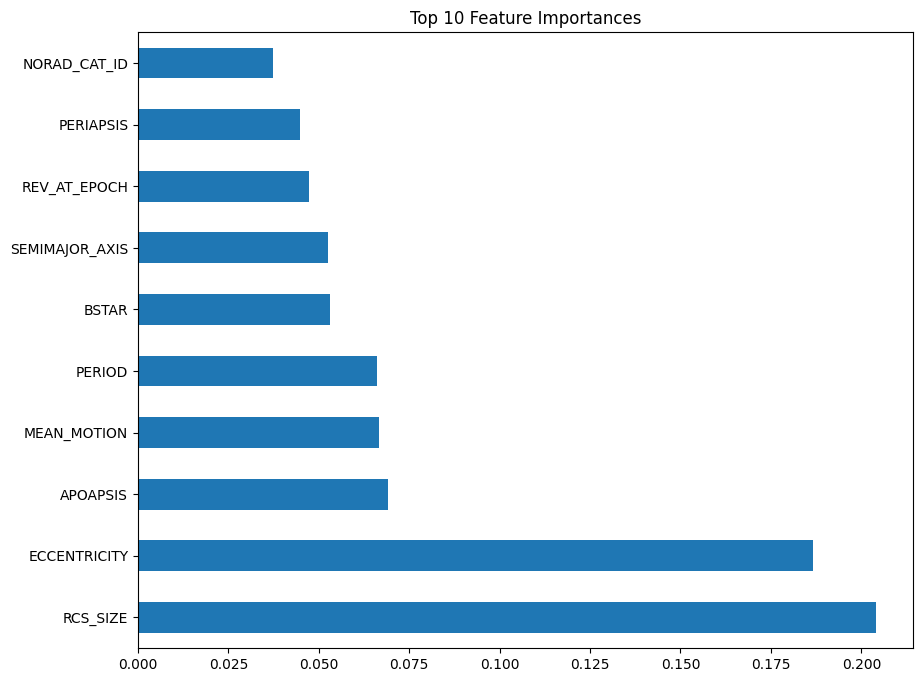

In [23]:
# Feature Importance
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 8))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()

In [24]:
# Save the Model
joblib.dump(best_rf_model, 'space_debris_predictor.pkl')

['space_debris_predictor.pkl']

In [26]:
# Check the shape of the input data
print("Input data shape:", user_input.shape)

# Check the number of features expected by the model
print("Number of features expected by the model:", len(model.feature_importances_))

Number of features expected by the model: 23


In [27]:
data

,CCSDS_OMM_VERS,CREATION_DATE,OBJECT_ID,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,...,SEMIMAJOR_AXIS,PERIOD,APOAPSIS,PERIAPSIS,OBJECT_TYPE,RCS_SIZE,COUNTRY_CODE,LAUNCH_DATE,FILE,GP_ID
0,2,2021-11-01 06:46:11,1992-072J,2.921700,0.652893,7.7156,90.2410,243.1216,38.7796,0,...,20668.618,492.864,27784.871,796.095,0,1,29,1970-01-01 00:00:00.000001992,3195178,188614016
1,2,2021-11-01 04:58:37,1979-028C,13.754973,0.003072,82.9193,299.1120,158.9093,201.3337,0,...,7358.038,104.689,1002.507,957.299,0,2,18,1970-01-01 00:00:00.000001979,3194950,188593285
2,2,2021-11-01 06:26:11,2001-015A,1.038224,0.023739,12.1717,16.5368,250.1248,146.2900,0,...,41197.852,1386.984,35797.696,33841.738,1,0,36,1970-01-01 00:00:00.000002001,3195026,188609573
3,2,2021-10-31 18:07:15,1999-057MB,14.775907,0.006062,98.4781,8.7205,37.3771,323.1632,0,...,7015.076,97.456,679.465,594.417,0,2,67,1970-01-01 00:00:00.000001999,3194431,188556894
4,2,2021-11-01 04:58:37,1999-057MC,14.724482,0.006226,98.4232,122.0724,345.1605,27.6061,0,...,7031.400,97.796,697.039,609.491,0,2,67,1970-01-01 00:00:00.000001999,3194950,188592541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14367,2,2021-10-29 18:22:04,1961-015MN,15.465781,0.001190,99.0098,214.6827,219.1613,140.8771,0,...,6804.882,93.109,434.844,418.650,3,3,95,NaT,3191411,188414015
14368,2,2021-10-31 18:06:35,1961-015MN,14.967557,0.005560,99.0272,141.1159,76.8926,283.8489,0,...,6955.066,96.208,615.599,538.263,3,3,95,NaT,3194430,188550573
14369,2,2021-10-31 18:07:15,1961-015MN,12.909691,0.056673,31.9916,262.9339,162.7824,199.2858,0,...,7675.817,111.544,1732.692,862.672,3,3,95,NaT,3194431,188561362
14370,2,2021-10-31 18:07:15,1961-015MN,14.245319,0.005822,98.6758,348.3068,187.0288,173.0081,0,...,7188.204,101.086,851.919,768.219,3,3,95,NaT,3194431,188561387


Initial Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14372 entries, 0 to 14371
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CCSDS_OMM_VERS       14372 non-null  int64  
 1   COMMENT              14372 non-null  object 
 2   CREATION_DATE        14372 non-null  object 
 3   ORIGINATOR           14372 non-null  object 
 4   OBJECT_NAME          14372 non-null  object 
 5   OBJECT_ID            14333 non-null  object 
 6   CENTER_NAME          14372 non-null  object 
 7   REF_FRAME            14372 non-null  object 
 8   TIME_SYSTEM          14372 non-null  object 
 9   MEAN_ELEMENT_THEORY  14372 non-null  object 
 10  EPOCH                14372 non-null  object 
 11  MEAN_MOTION          14372 non-null  float64
 12  ECCENTRICITY         14372 non-null  float64
 13  INCLINATION          14372 non-null  float64
 14  RA_OF_ASC_NODE       14372 non-null  float64
 15  ARG_OF_PERICE

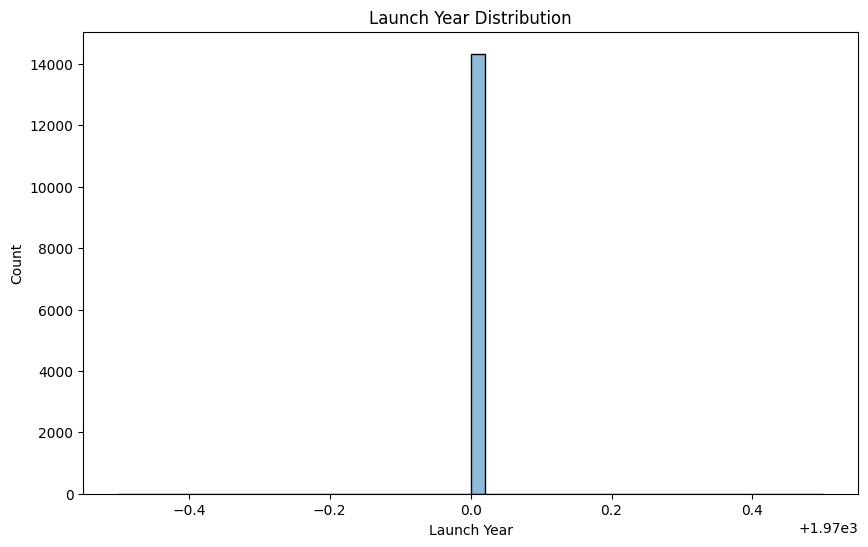

C:\Users\jaya sai srikar\AppData\Local\Temp\ipykernel_68856\2757415316.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=space_data, x='RCS_SIZE', palette='coolwarm')


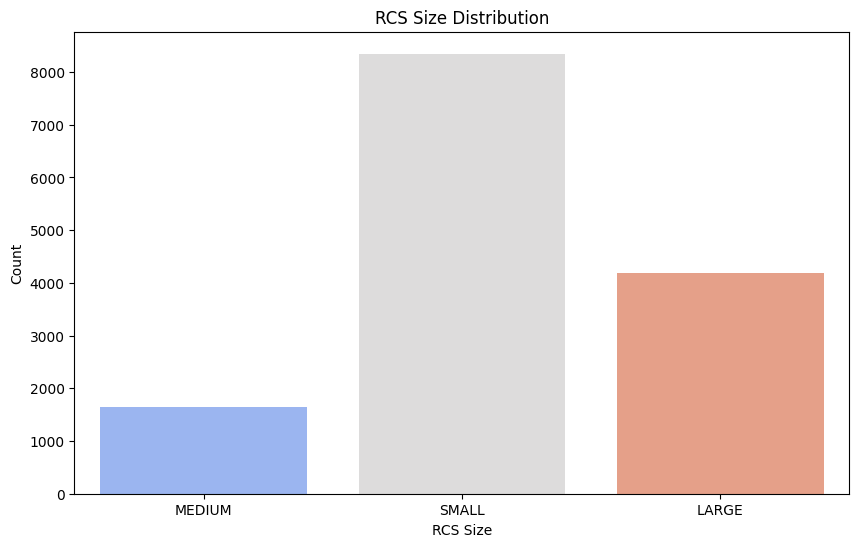

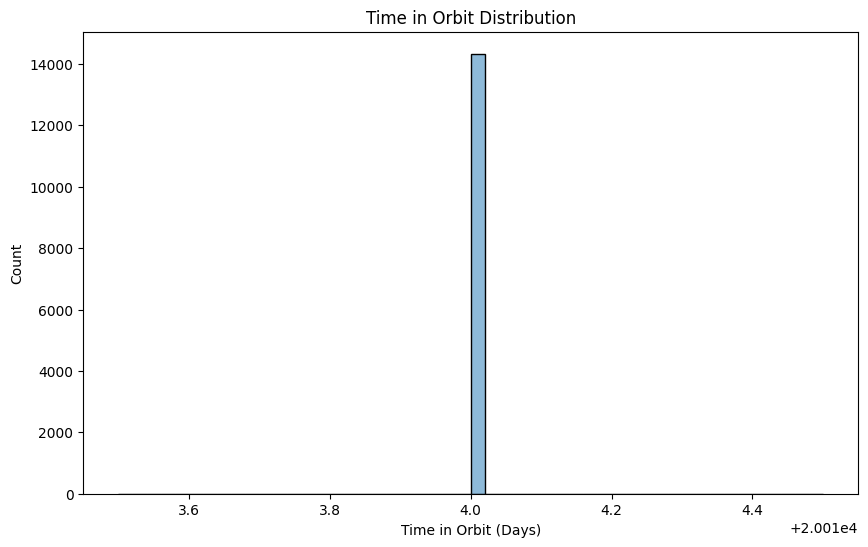

Model Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4300

    accuracy                           1.00      4300
   macro avg       1.00      1.00      1.00      4300
weighted avg       1.00      1.00      1.00      4300

Model saved as 'space_debris_predictor.pkl'


c:\Users\jaya sai srikar\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the dataset
space_data = pd.read_csv('space_decay.csv')

# ------------------------ EDA ------------------------
print("Initial Data Overview:")
print(space_data.info())
print(space_data.describe())

# Convert dates
space_data['LAUNCH_DATE'] = pd.to_datetime(space_data['LAUNCH_DATE'], errors='coerce')
space_data['DECAY_DATE'] = pd.to_datetime(space_data['DECAY_DATE'], errors='coerce')

# Check missing values
print("\nMissing values per column:")
print(space_data.isnull().sum())

# Create Time_In_Orbit feature (difference between launch and decay date)
space_data['Time_In_Orbit'] = (space_data['DECAY_DATE'].fillna(pd.Timestamp.today()) - space_data['LAUNCH_DATE']).dt.days

# Map RCS_SIZE to numerical values
size_mapping = {'SMALL': 1, 'MEDIUM': 2, 'LARGE': 3}
space_data['RCS_SIZE_NUM'] = space_data['RCS_SIZE'].map(size_mapping)

# Label encoding for Country Code
le = LabelEncoder()
space_data['COUNTRY_CODE_ENC'] = le.fit_transform(space_data['COUNTRY_CODE'])

# ------------------------ Visualizations (EDA) ------------------------
# Launch Year distribution
space_data['Launch_Year'] = space_data['LAUNCH_DATE'].dt.year
plt.figure(figsize=(10, 6))
sns.histplot(space_data['Launch_Year'].dropna(), bins=50, kde=True)
plt.title("Launch Year Distribution")
plt.xlabel("Launch Year")
plt.ylabel("Count")
plt.show()

# RCS Size distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=space_data, x='RCS_SIZE', palette='coolwarm')
plt.title("RCS Size Distribution")
plt.xlabel("RCS Size")
plt.ylabel("Count")
plt.show()

# Time in Orbit distribution
plt.figure(figsize=(10, 6))
sns.histplot(space_data['Time_In_Orbit'].dropna(), bins=50, kde=True)
plt.title("Time in Orbit Distribution")
plt.xlabel("Time in Orbit (Days)")
plt.ylabel("Count")
plt.show()

# ------------------------ Preprocessing ------------------------
# Remove rows with missing launch date and negative Time_In_Orbit
space_data = space_data.dropna(subset=['LAUNCH_DATE'])
space_data = space_data[space_data['Time_In_Orbit'] >= 0]

# Define features and target
X = space_data[['Time_In_Orbit', 'RCS_SIZE_NUM', 'COUNTRY_CODE_ENC']]
y = space_data['DECAY_DATE'].notnull().astype(int)  # 1 if decayed, 0 otherwise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ------------------------ Model Training (XGBoost) ------------------------
# Initialize and train the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Predictions and model evaluation
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model as 'space_debris_predictor.pkl'
joblib.dump(xgb_model, 'space_debris_predictor.pkl')
print("Model saved as 'space_debris_predictor.pkl'")
